# Сканнер судоку

В этом задании, вам предлагается решить задачу распознавания чисел на решетке судоку. Для этого вам нужно реализовать следующие функции:

1. Конвертация в нужное цветовое пространство
2. Поиск решетки на изображении через контуры
3. Перспектива решетки судоку для распознавания
4. Выделение ячеек с числами
5. Обучение нейронной сети на MNIST
6. Распознавание цифр в судоку с помощью сети

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def READ_RGB(path):
    image=cv2.imread(path)
    return cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

def SHOW_IMAGE(image):
    plt.imshow(image,cmap='gray')
    plt.show()

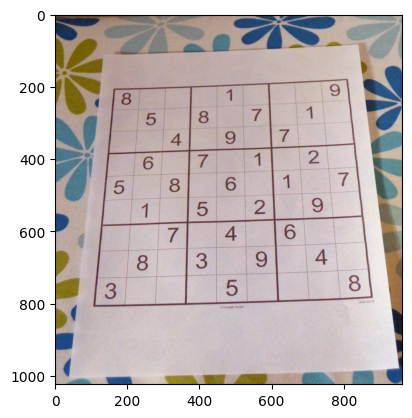

In [3]:
# Загружаем изображение
img_rgb = READ_RGB("opencv_sudoku_puzzle_sudoku_puzzle.jpg")
SHOW_IMAGE(img_rgb)

## Бинаризация

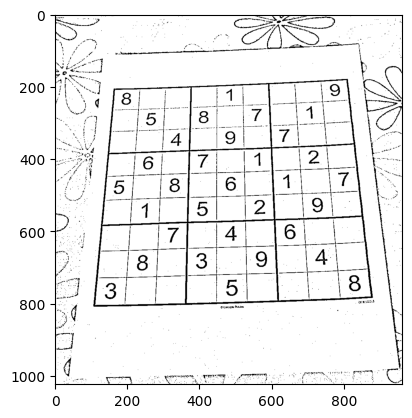

In [4]:
# Перевод из RBG в Grayscale и накладываем фильтр
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2GRAY)

# Бинаризация
img_bin = cv2.adaptiveThreshold(
    img_gray,
    255, # Максимальное значение после применения порога (белый цвет)
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, # Метод вычисления порога: по средневзвешенному значению с Гауссовым ядром
    cv2.THRESH_BINARY, # Тип пороговой обработки.
    # cv2.THRESH_BINARY_INV - инвертированная бинаризация (0 → 255, 255 → 0)
    15, # Размер блока (нечетное число), в котором ищется локальный порог
    12 # Константа C, вычитаемая из среднего или взвешенного значения (регулирует контраст)
)
SHOW_IMAGE(img_bin)

**Пояснение ключевых параметров:**

  - cv2.ADAPTIVE_THRESH_GAUSSIAN_C: Использует взвешенное среднее (Гауссово) значение блока — лучше при нерезких краях.

  - cv2.THRESH_BINARY_INV: Инвертирует результат. Те пиксели, которые больше локального порога, станут чёрными (0), остальные — белыми (255). Это удобно для выделения белых цифр и линий на чёрном фоне.

  - cv2.THRESH_BINARY: выделения черных цифр и линий на белом фоне.

  - blockSize = 15: Размер области (в пикселях), по которой вычисляется локальный порог. Чем больше — тем сильнее усреднение.

  - C = 12: Смещает значение порога вниз. Это позволяет "усилить" контраст цифр, вычитая значение C из среднего.

## Поиск контуров

На этом этапе мы хотим найти решетку с судоку. По нашему предположению, это наибольший по площади четырехугольник

In [5]:
# Функция для уменьшения ребер в контуре
def Approximating(contour,epsilon=.1):
    # Периметр контура
    length=cv2.arcLength(contour,True)
    # Аппроксимирует контурную форму к форме с меньшим количеством вершин
    # в зависимости от указанной точности. Это реализация алгоритма Рамера — Дугласа — Пекера.
    approx=cv2.approxPolyDP(contour,epsilon*length,True)
    return approx

In [6]:
# Найдите контуры с помощью opencv
contours, hierarcy = cv2.findContours(img_bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

In [7]:
hierarcy

array([[[  12,   -1,    1,   -1],
        [   2,   -1,   -1,    0],
        [   3,    1,   -1,    0],
        ...,
        [2196, 2194,   -1,   14],
        [2197, 2195,   -1,   14],
        [  -1, 2196,   -1,   14]]], dtype=int32)

In [8]:
img_contours = img_rgb.copy()

# Отсортируйте контуры по площади
contours_sorted = sorted(contours, key=cv2.contourArea, reverse=True)

# Аппроксимируйте контуры, чтобы с бОльшей вероятностью получить четырехугольник
approx_contours = [Approximating(cnt, epsilon=0.02) for cnt in contours_sorted]

# Выберите только те контуры, которые являются четырехугольникам
approx_rect = [cnt for cnt in approx_contours if len(cnt) == 4]
approx_rect = sorted(approx_rect, key=cv2.contourArea, reverse=True)

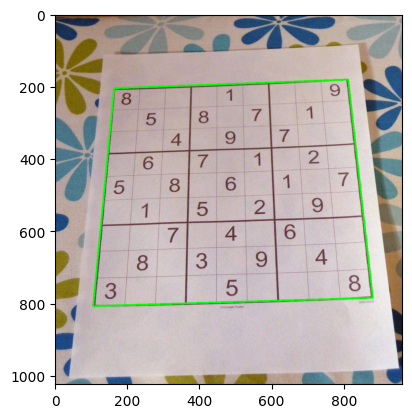

In [9]:
cv2.drawContours(img_contours, approx_rect, 0, (0, 255, 0), 3)
SHOW_IMAGE(img_contours)

## WarpTransform

На этом этапе, мы сделаем перспективу решетки на новое изображение. Размерность нового изображения мы можем задать сами, поэтому упростим себе жизнь: пусть размер каждой ячейки будет 28x28, чтобы без лишних трансформаций отправлять их в нейронную сеть. Количество ячеек в судоку - 9 на 9. Таким образом, длина и ширина изображения будут 9x28 (мы не учитываем толщину линий между ячейчками)

In [10]:
img_contours = img_rgb.copy()

### Первый способ трансформации

In [11]:
# используем функцию с лекции
def four_point_transform_by_hand(image, pts):
    # obtain a consistent order of the points and unpack them individually
    pts = pts.reshape(4, 2)
    def order_points(pts):
        rect = np.zeros((4, 2), dtype = "float32")
        s = pts.sum(axis = 1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis = 1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        return rect

    rect = order_points(pts)
    (tl, tr, br, bl) = rect
    # compute the width of the new image, which will be the
    # maximum distance between bottom-right and bottom-left
    # x-coordiates or the top-right and top-left x-coordinates
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))
    # compute the height of the new image, which will be the
    # maximum distance between the top-right and bottom-right
    # y-coordinates or the top-left and bottom-left y-coordinates
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))
    # now that we have the dimensions of the new image, construct
    # the set of destination points to obtain a "birds eye view",
    # (i.e. top-down view) of the image, again specifying points
    # in the top-left, top-right, bottom-right, and bottom-left order
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # compute the perspective transform matrix and then apply it
    M = cv2.getPerspectiveTransform(rect, dst)
    print(f'Длина изображения: {maxWidth}, Высота изображения: {maxHeight}')
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    # return the warped image
    return warped

Длина изображения: 773, Высота изображения: 607


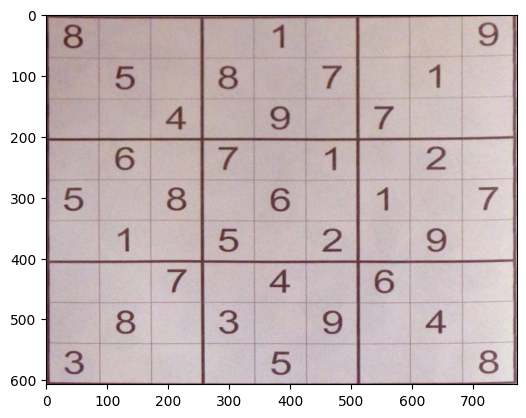

In [12]:
# Размер трансформированного изображения пропорционален оригинальной решетке
warped_var_1 = four_point_transform_by_hand(img_contours, approx_rect[0].reshape(4, 2))
SHOW_IMAGE(warped_var_1)

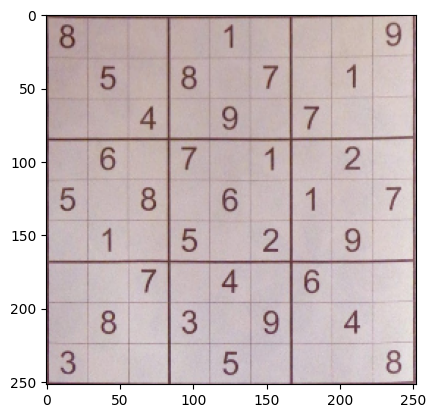

In [13]:
# Привели к размеру 252х252

output_size = 28 * 9
warped_var_1 = cv2.resize(warped_var_1, (output_size, output_size))
SHOW_IMAGE(warped_var_1)

### Второй способ трансформации

In [14]:
# !pip install imutils

In [15]:
# по сути та же функция, что вручную реализована ранее
from imutils.perspective import four_point_transform

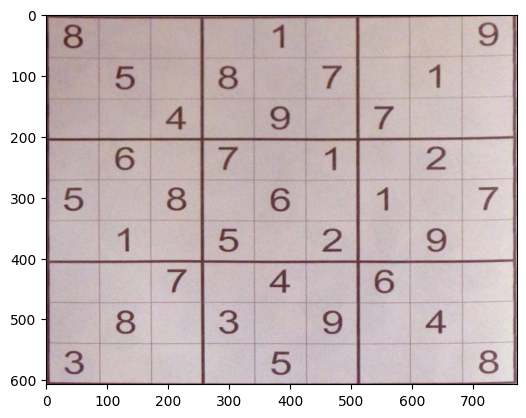

In [16]:
# Размер трансформированного изображения пропорционален оригинальной решетке
warped_var_2 = four_point_transform(img_contours, approx_rect[0].reshape(4, 2))
SHOW_IMAGE(warped_var_2)

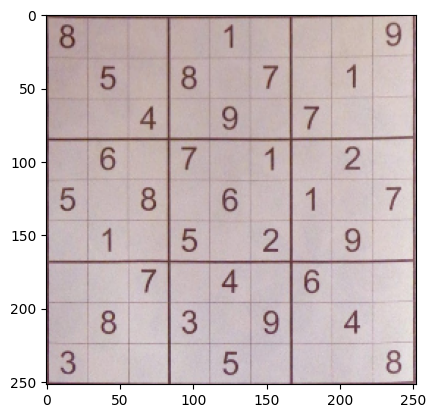

In [17]:
# Привели к размеру 252х252

output_size = 28 * 9
warped_var_2 = cv2.resize(warped_var_2, (output_size, output_size))
SHOW_IMAGE(warped_var_2)

### Третий способ трансформации (как планировалось в задании изначально)

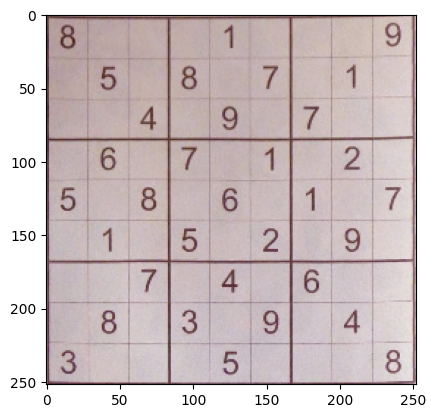

In [18]:
img_contours = img_rgb.copy()

output_size = 28 * 9
# Вытаскиваем контур решетки
sudoku_contour = approx_rect[0].reshape(4, 2)

# Функция для упорядочивания углов: [верх-лево, верх-право, низ-право, низ-лево]
def order_points(pts):
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]  # верх-левый (x+y минимально)
    rect[2] = pts[np.argmax(s)]  # низ-правый (x+y максимально)

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]  # верх-правый (x - y минимально)
    rect[3] = pts[np.argmax(diff)]  # низ-левый (x - y максимально)

    return rect

# Упорядочим углы и зададим точки назначения
src_pts = order_points(sudoku_contour)
dst_pts = np.array([
    [0, 0],
    [output_size - 1, 0],
    [output_size - 1, output_size - 1],
    [0, output_size - 1]
], dtype="float32")

# Получаем матрицу трансформации и применяем её
M = cv2.getPerspectiveTransform(src_pts, dst_pts)
warped = cv2.warpPerspective(img_contours, M, (output_size, output_size))

SHOW_IMAGE(warped)

## Разделение

Дальше ячейки будем делить не по линиям на изображении, а по предварительным расчетам, что каждая цифра находится в ячейке размером 28 на 28, а размерность решетки судоку 9 на 9

В ячейки может попасть мусор в виде границ между ячейками. От него можно избавиться с помощью великолепной функции `clear_border`, которая удаляет все ненужные части изображения по краям.

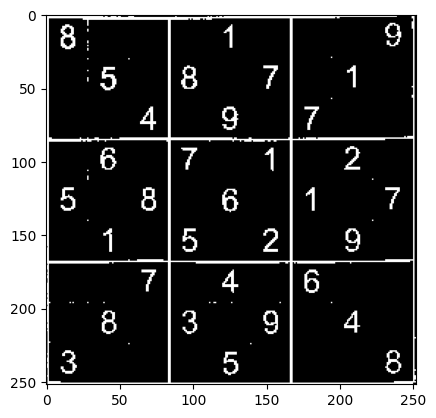

In [19]:
gray = cv2.cvtColor(warped,cv2.COLOR_RGB2GRAY)
_, warped_binary = cv2.threshold(gray,0,255,cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
SHOW_IMAGE(warped_binary)

In [20]:
from skimage.segmentation import clear_border

nCols = 9
nRows = 9
size = 28

grid = []
for i in range(0, nRows):
    grid.append([])
    for j in range(0, nCols):
      # Вычисляем координаты текущей ячейки
      start_row = i * size
      end_row = (i + 1) * size
      start_col = j * size
      end_col = (j + 1) * size
      # Добавьте в grid соответствующий кусок изображения
      subImg = warped_binary[start_row:end_row, start_col:end_col]
      grid[i].append(clear_border(subImg))

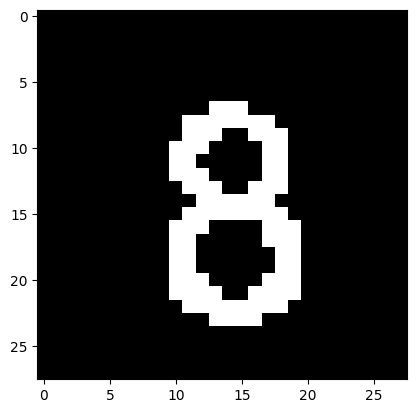

In [21]:
SHOW_IMAGE(grid[0][0])

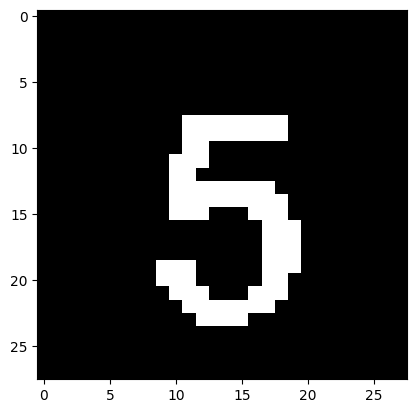

In [22]:
SHOW_IMAGE(grid[1][1])

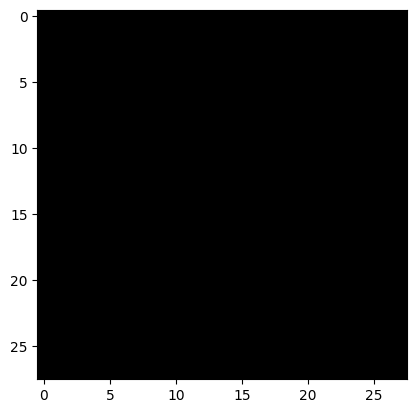

In [23]:
SHOW_IMAGE(grid[0][1])

## Обучение сети для распознавания

Обучим простую сеть для распознавания цифр на MNIST. Поскольку вы уже делали похожие задания, здесь ничего дописывать не обязательно, код вернет приличную нейронку `model`, хотя вы можете попробовать по-экспериментировать с ней

In [24]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Set random seed for reproducibility
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 5

# Data augmentation and normalization for training
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data',
                                         train=True,
                                         download=True,
                                         transform=transform)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                        train=False,
                                        download=True,
                                        transform=transforms.ToTensor())

# Data loader
train_loader = DataLoader(dataset=train_dataset,
                         batch_size=batch_size,
                         shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                        batch_size=batch_size,
                        shuffle=False)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Initialize model, loss function and optimizer
model = NeuralNetwork().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data to device
        data, target = data.to(device), target.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)} '
                  f'({100.*batch_idx/len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

def test():
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == target).sum().item()

    accuracy = correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss/len(test_loader):.4f}, '
          f'Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({100.*accuracy:.0f}%)\n')

# Train the model
for epoch in range(1, num_epochs + 1):
    train(epoch)
    test()

print("Training completed!")

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 490kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.57MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.19MB/s]


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.294706
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.352323
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.114129
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.207604
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.188276
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.140513
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.119144
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.107769
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.256881
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.101907

Test set: Average loss: 0.4439, Accuracy: 9614/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.156121
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.136541
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.040265
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.166755
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.053691
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.021895
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.081855
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.163026
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.088439
T

## Итоговое распознавание

Теперь мы можем проверить, как работает нейронка на кусках изображения из нашего судоку. Поскольку у модели нет класса "пустое изображение", которые встречается в нашем случае, придется отфильтровывать такие ячейки. Мы сделаем это из предположение, что если в ячейке нет контуров, то она пустая.

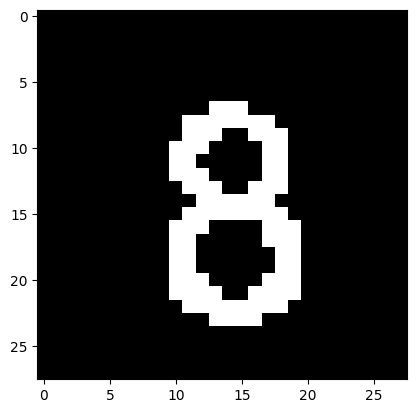

(0,0): Распознано число 8
(0,1): Пустая ячейка
(0,2): Пустая ячейка
(0,3): Пустая ячейка


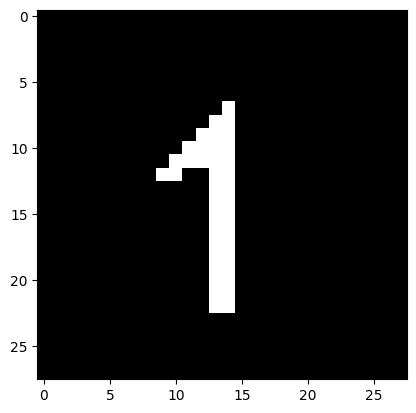

(0,4): Распознано число 1
(0,5): Пустая ячейка
(0,6): Пустая ячейка
(0,7): Пустая ячейка


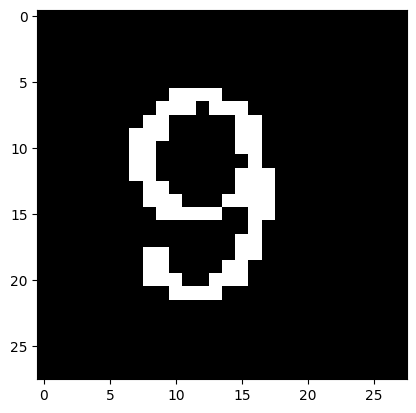

(0,8): Распознано число 8
(1,0): Пустая ячейка


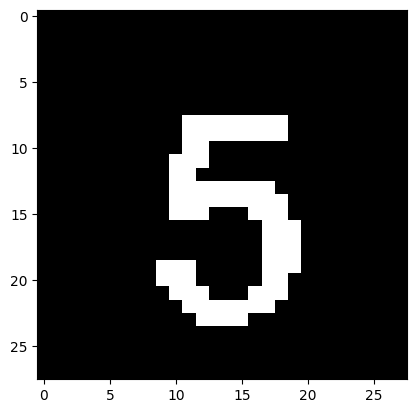

(1,1): Распознано число 5
(1,2): Пустая ячейка


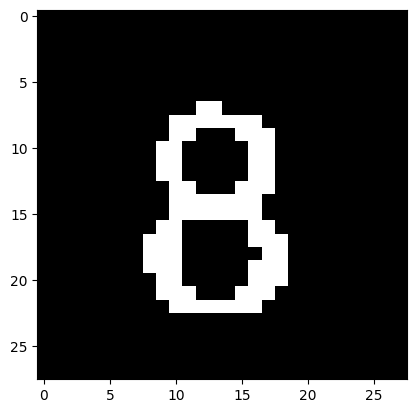

(1,3): Распознано число 8
(1,4): Пустая ячейка


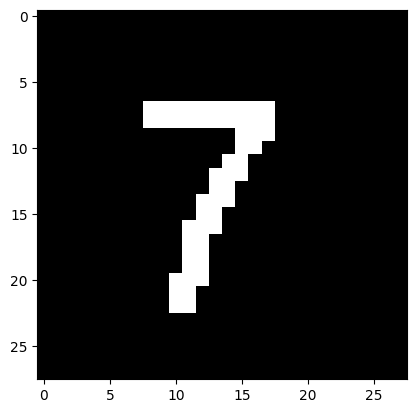

(1,5): Распознано число 7


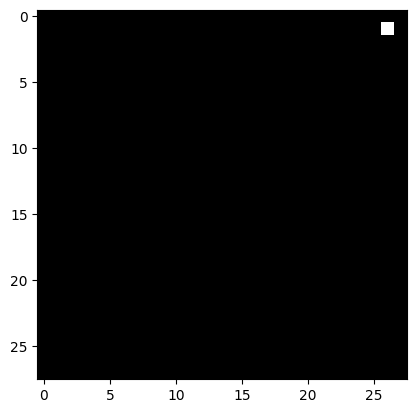

(1,6): Распознано число 5


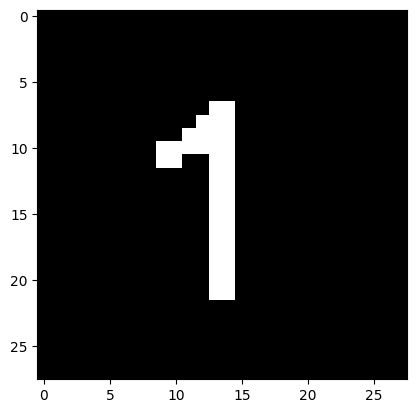

(1,7): Распознано число 1
(1,8): Пустая ячейка
(2,0): Пустая ячейка
(2,1): Пустая ячейка


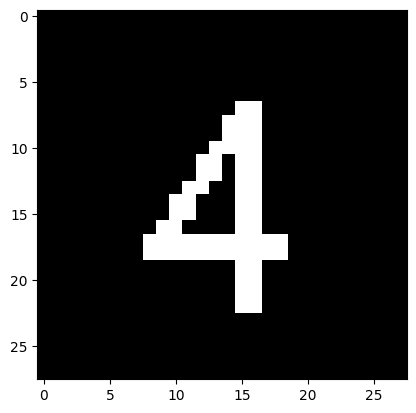

(2,2): Распознано число 4
(2,3): Пустая ячейка


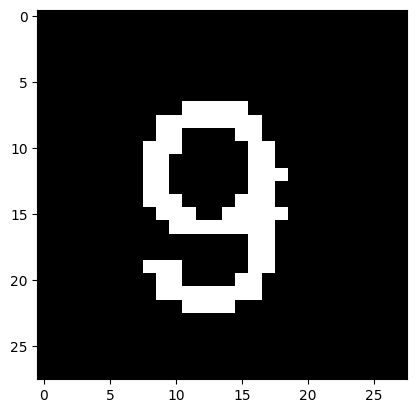

(2,4): Распознано число 9
(2,5): Пустая ячейка


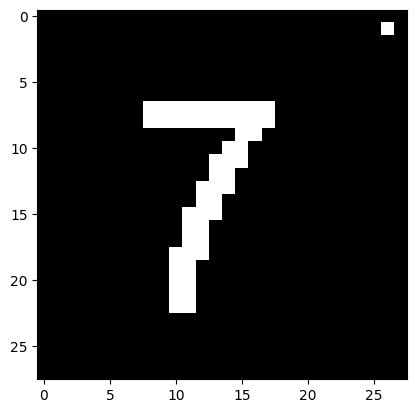

(2,6): Распознано число 7
(2,7): Пустая ячейка
(2,8): Пустая ячейка
(3,0): Пустая ячейка


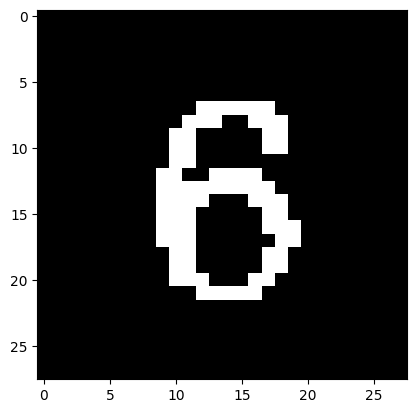

(3,1): Распознано число 5
(3,2): Пустая ячейка


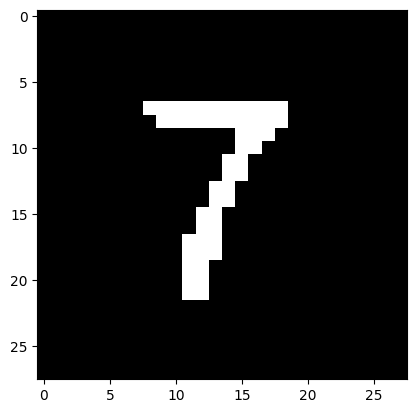

(3,3): Распознано число 7
(3,4): Пустая ячейка


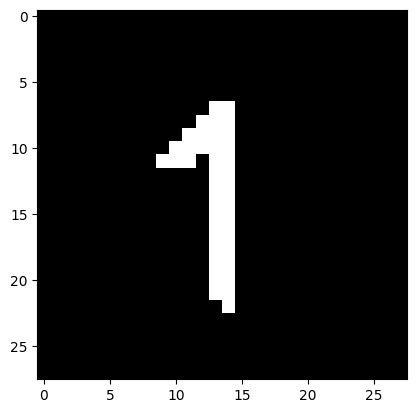

(3,5): Распознано число 1
(3,6): Пустая ячейка


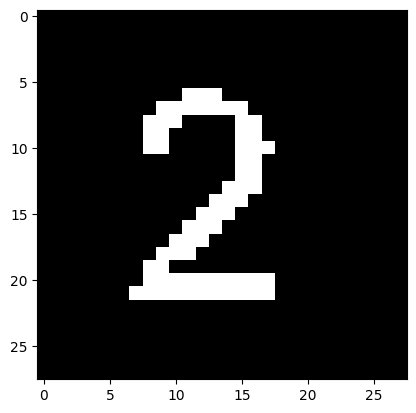

(3,7): Распознано число 2
(3,8): Пустая ячейка


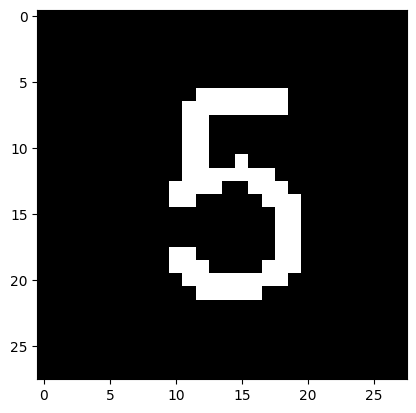

(4,0): Распознано число 5
(4,1): Пустая ячейка


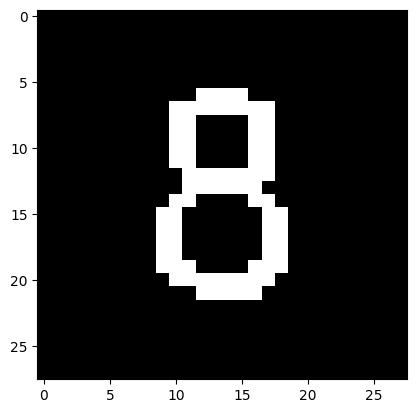

(4,2): Распознано число 8
(4,3): Пустая ячейка


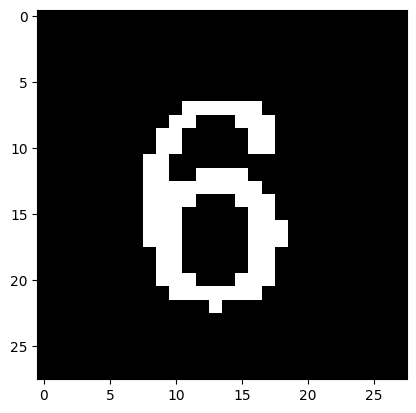

(4,4): Распознано число 4
(4,5): Пустая ячейка


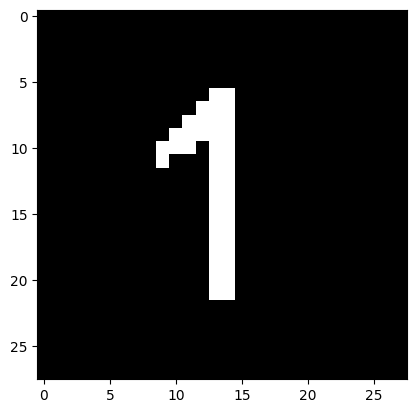

(4,6): Распознано число 1
(4,7): Пустая ячейка


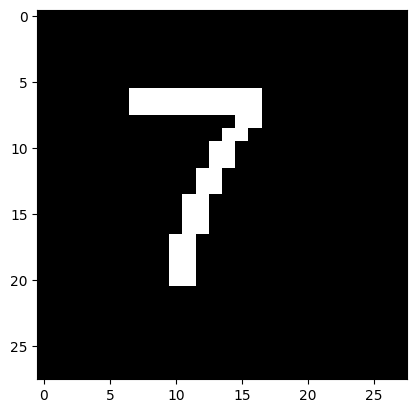

(4,8): Распознано число 2
(5,0): Пустая ячейка


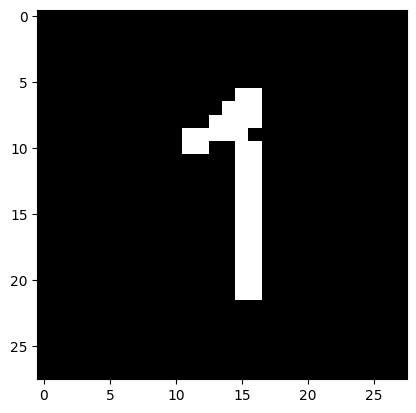

(5,1): Распознано число 1
(5,2): Пустая ячейка


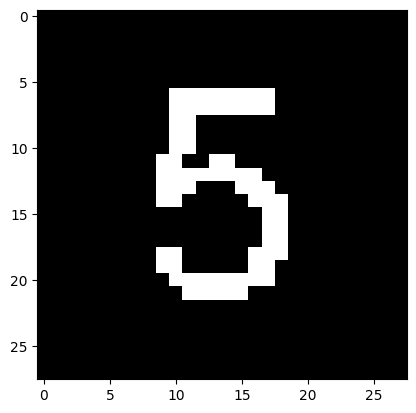

(5,3): Распознано число 5
(5,4): Пустая ячейка


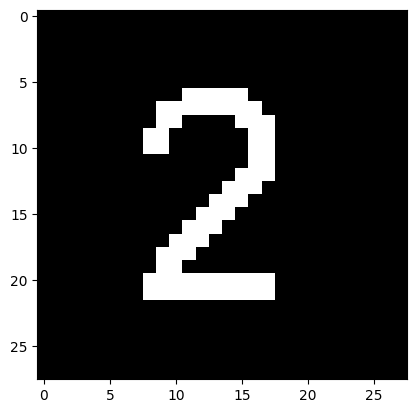

(5,5): Распознано число 2
(5,6): Пустая ячейка


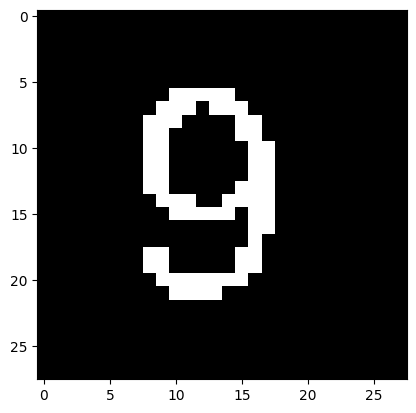

(5,7): Распознано число 9
(5,8): Пустая ячейка
(6,0): Пустая ячейка
(6,1): Пустая ячейка


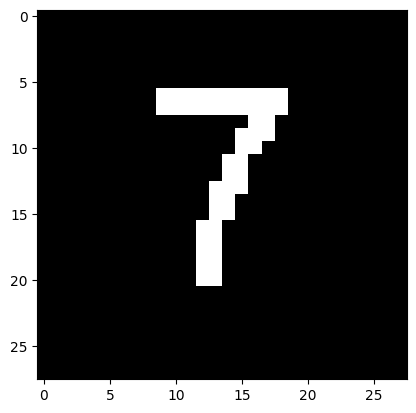

(6,2): Распознано число 7
(6,3): Пустая ячейка


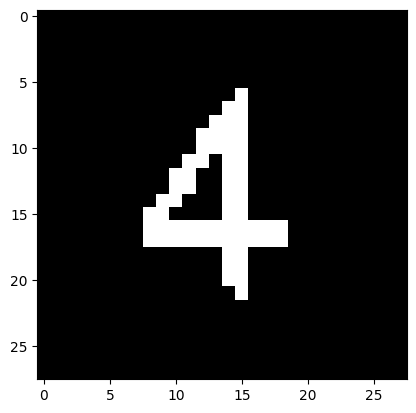

(6,4): Распознано число 4
(6,5): Пустая ячейка


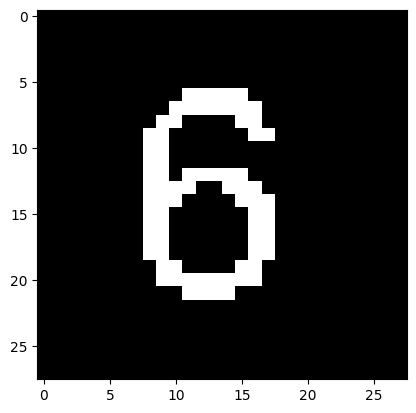

(6,6): Распознано число 8
(6,7): Пустая ячейка
(6,8): Пустая ячейка
(7,0): Пустая ячейка


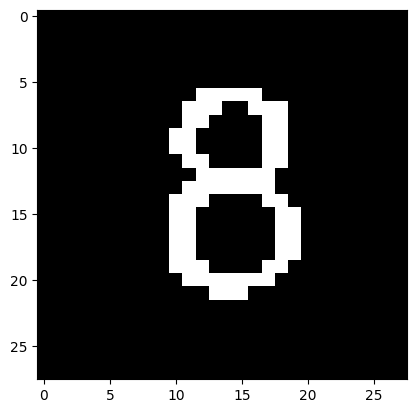

(7,1): Распознано число 3
(7,2): Пустая ячейка


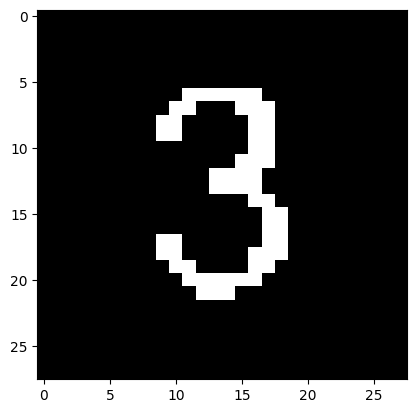

(7,3): Распознано число 3
(7,4): Пустая ячейка


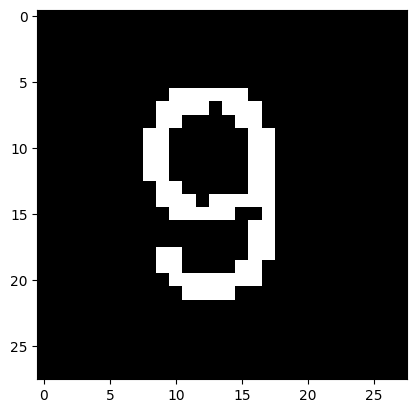

(7,5): Распознано число 9
(7,6): Пустая ячейка


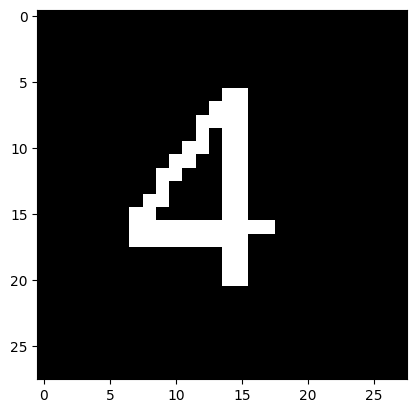

(7,7): Распознано число 4
(7,8): Пустая ячейка


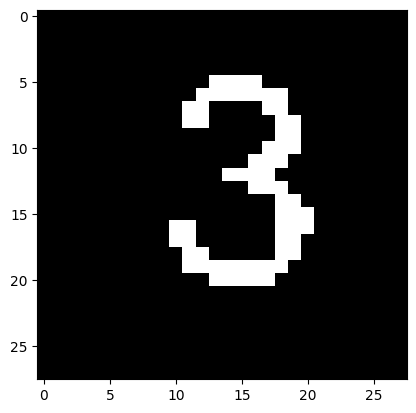

(8,0): Распознано число 2
(8,1): Пустая ячейка
(8,2): Пустая ячейка
(8,3): Пустая ячейка


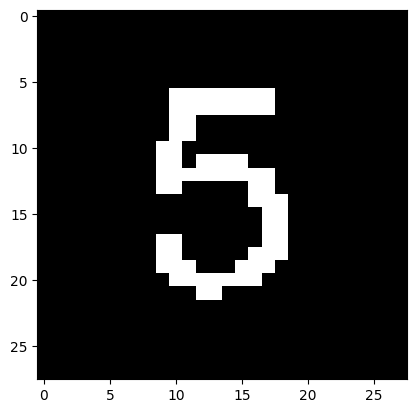

(8,4): Распознано число 5
(8,5): Пустая ячейка
(8,6): Пустая ячейка
(8,7): Пустая ячейка


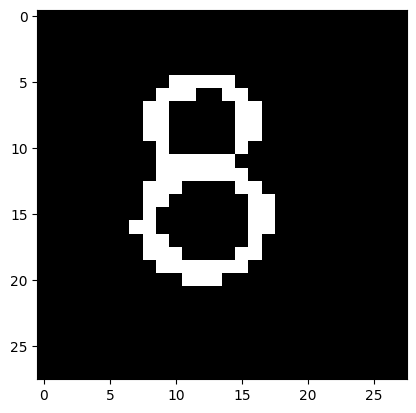

(8,8): Распознано число 5

Всего распознанных ячеек: 34
Всего пустых ячеек: 47


In [27]:
recognized_count = 0 # Кол-во ячеек с цифрами
empty_count = 0 # Кол-во пустых

for i in range(0, nRows):
    for j in range(0, nCols):
        bb = grid[i][j]

        # Если в bb нет конкуров, выведите об этом сообщение. Иначе, отправьте bb в нейронку
        # и выведите предсказание. Не забудьте, что bb имеет размерность (28,28),
        # а нейронка работает с тензорами размерности (batch_size,1,28,28).

        # Ищем контуры — если нет, считаем ячейку пустой
        contours, _ = cv2.findContours(bb, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0:
            print(f"({i},{j}): Пустая ячейка")
            empty_count += 1
        else:
            # Подготовим изображение к подаче в сеть
            bb_tensor = torch.tensor(bb, dtype=torch.float32) / 255.0  # нормализация
            bb_tensor = (bb_tensor - 0.1307) / 0.3081  # та же нормализация, что при обучении
            bb_tensor = bb_tensor.unsqueeze(0).unsqueeze(0).to(device)  # (1, 1, 28, 28)

            # Предсказание
            model.eval()
            with torch.no_grad():
                output = model(bb_tensor)
                pred = output.argmax(dim=1, keepdim=True)

            SHOW_IMAGE(grid[i][j])
            print(f"({i},{j}): Распознано число {pred.item()}")
            recognized_count += 1

print(f"\nВсего распознанных ячеек: {recognized_count}")
print(f"Всего пустых ячеек: {empty_count}")

Видим, что распознано 34 ячейки с цифрами, хотя их должно быть 33, ячейка с координатами (1,6) распозналась ошибочно. Также видим, что с ошибками распознались следующие ячейки:
- (0,8) - Распознано число 8 - по факту 9;
- (3,1) - Распознано число 5 - по факту 6;
- (4,4) - Распознано число 4 - по факту 6;
- (4,8) - Распознано число 2 - по факту 7;
- (6,6) - Распознано число 8 - по факту 6;
- (7,1) - Распознано число 3 - по факту 8;
- (8,0) - Распознано число 2 - по факту 3;
- (8,8) - Распознано число 5 - по факту 8.

Видим, что модель ошибается достаточно часто, примерно каждая 3 цифра распознана с ошибкой.

## Увеличим batchsize, num_epoch и уменьшеним learning_rate

In [30]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 128
learning_rate = 0.0005
num_epochs = 10

# Data augmentation and normalization for training
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data',
                                         train=True,
                                         download=True,
                                         transform=transform)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                        train=False,
                                        download=True,
                                        transform=transforms.ToTensor())

# Data loader
train_loader = DataLoader(dataset=train_dataset,
                         batch_size=batch_size,
                         shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                        batch_size=batch_size,
                        shuffle=False)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# Initialize model, loss function and optimizer
model = NeuralNetwork().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data to device
        data, target = data.to(device), target.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx*len(data)}/{len(train_loader.dataset)} '
                  f'({100.*batch_idx/len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

def test():
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == target).sum().item()

    accuracy = correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss/len(test_loader):.4f}, '
          f'Accuracy: {correct}/{len(test_loader.dataset)} '
          f'({100.*accuracy:.0f}%)\n')

# Train the model
for epoch in range(1, num_epochs + 1):
    train(epoch)
    test()

print("Training completed!")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.295314
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.237564
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.256164
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.115414
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.140645

Test set: Average loss: 0.8175, Accuracy: 9577/10000 (96%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.169721
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.036018
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.099712
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.085865
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.069952

Test set: Average loss: 0.5596, Accuracy: 9703/10000 (97%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.114061
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.035713
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.085497
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.063259
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.020512

Test set: Average loss: 0.4305, Accuracy: 9702/10000 (97%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.018923
Train Epoch: 4 [12800/60000 (21%)]	Lo

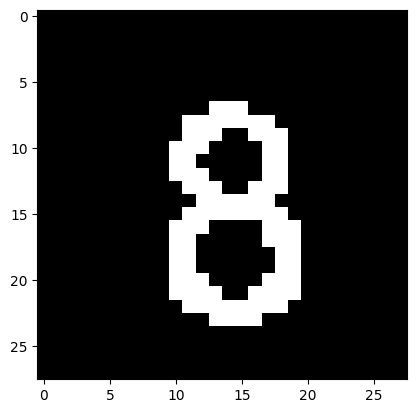

(0,0): Распознано число 8
(0,1): Пустая ячейка
(0,2): Пустая ячейка
(0,3): Пустая ячейка


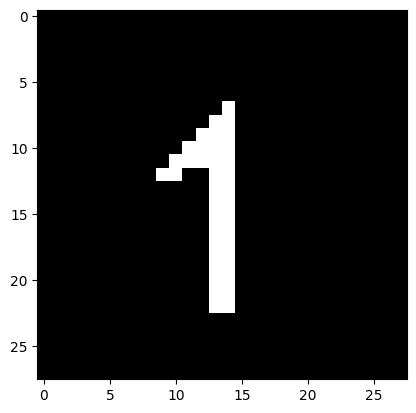

(0,4): Распознано число 1
(0,5): Пустая ячейка
(0,6): Пустая ячейка
(0,7): Пустая ячейка


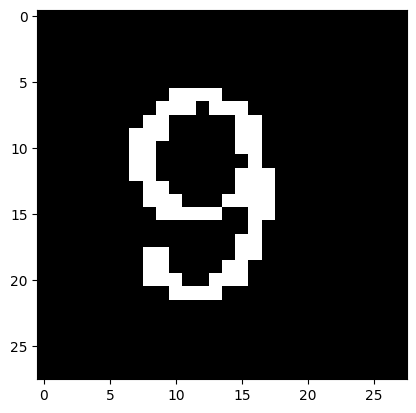

(0,8): Распознано число 9
(1,0): Пустая ячейка


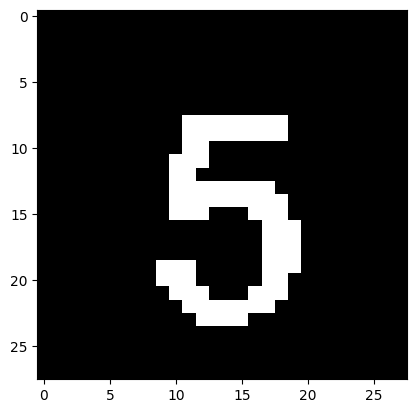

(1,1): Распознано число 5
(1,2): Пустая ячейка


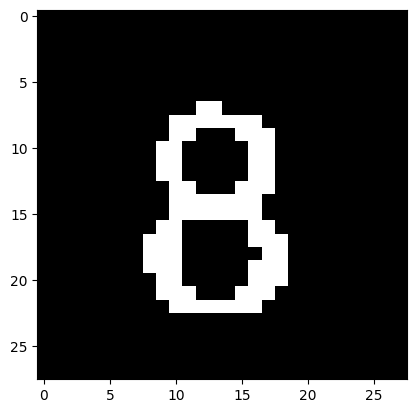

(1,3): Распознано число 8
(1,4): Пустая ячейка


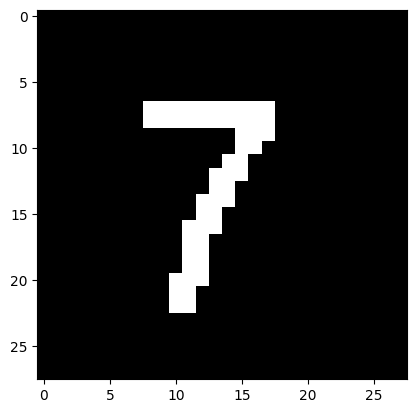

(1,5): Распознано число 7


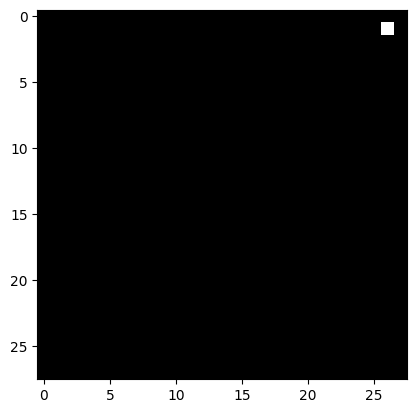

(1,6): Распознано число 1


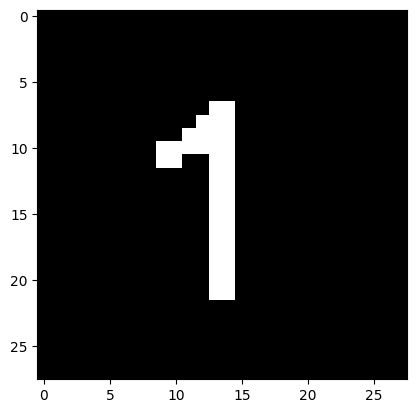

(1,7): Распознано число 1
(1,8): Пустая ячейка
(2,0): Пустая ячейка
(2,1): Пустая ячейка


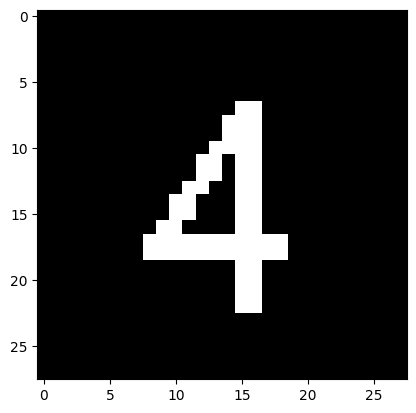

(2,2): Распознано число 4
(2,3): Пустая ячейка


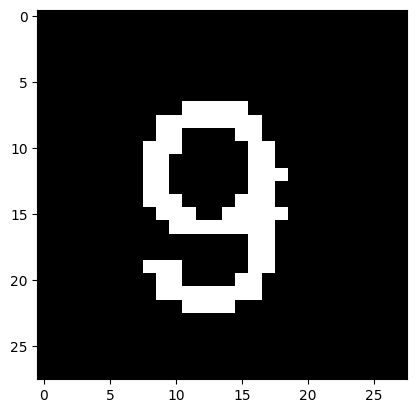

(2,4): Распознано число 9
(2,5): Пустая ячейка


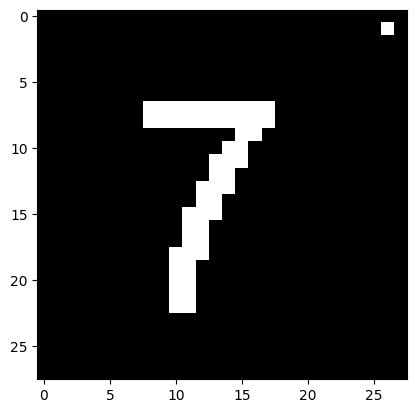

(2,6): Распознано число 7
(2,7): Пустая ячейка
(2,8): Пустая ячейка
(3,0): Пустая ячейка


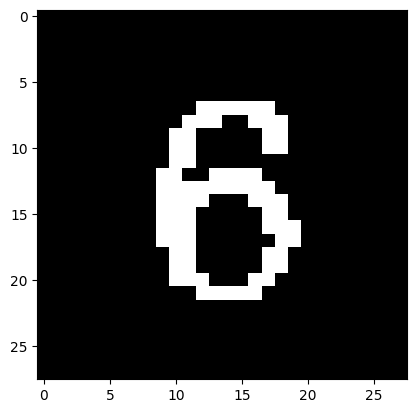

(3,1): Распознано число 5
(3,2): Пустая ячейка


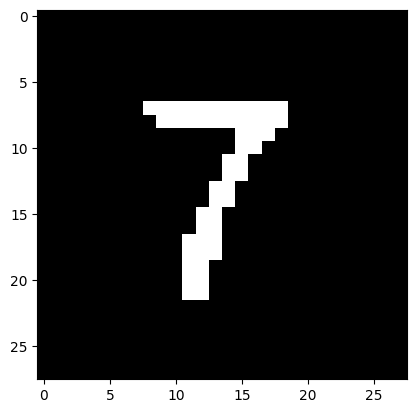

(3,3): Распознано число 7
(3,4): Пустая ячейка


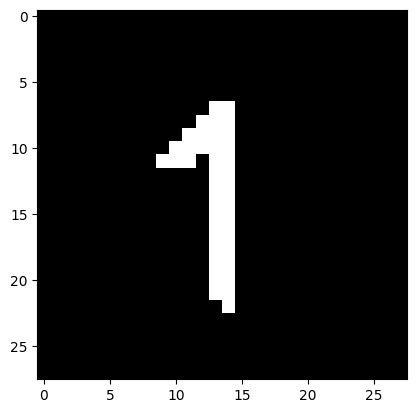

(3,5): Распознано число 1
(3,6): Пустая ячейка


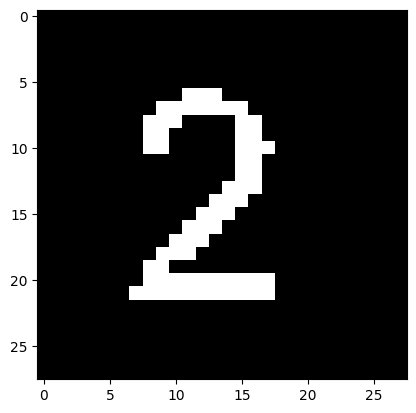

(3,7): Распознано число 2
(3,8): Пустая ячейка


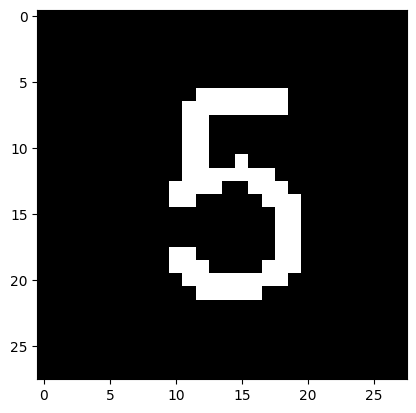

(4,0): Распознано число 5
(4,1): Пустая ячейка


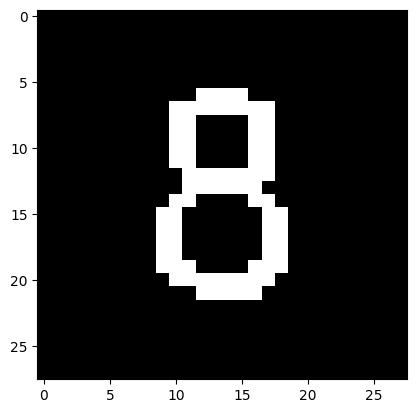

(4,2): Распознано число 8
(4,3): Пустая ячейка


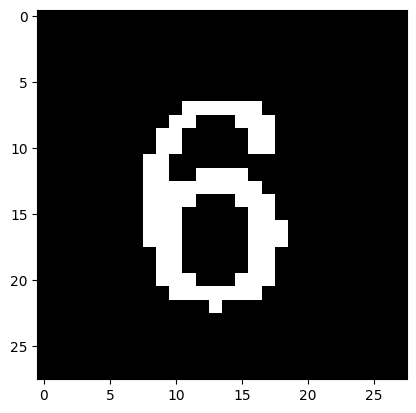

(4,4): Распознано число 6
(4,5): Пустая ячейка


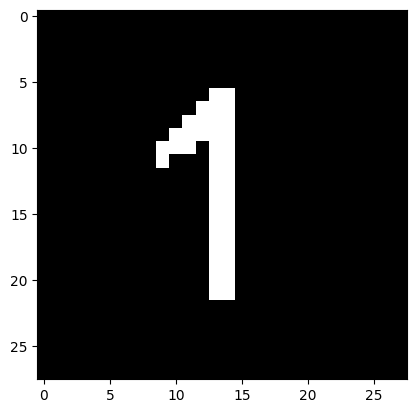

(4,6): Распознано число 1
(4,7): Пустая ячейка


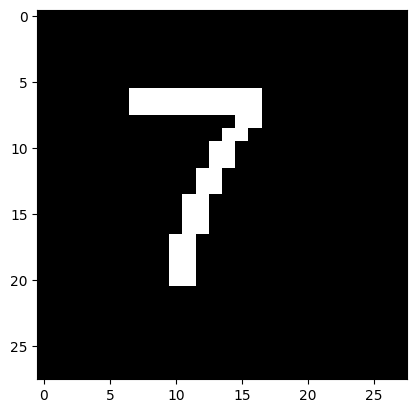

(4,8): Распознано число 2
(5,0): Пустая ячейка


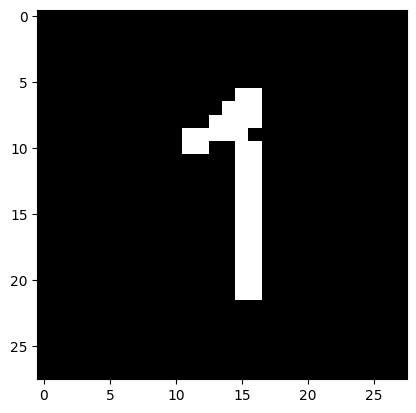

(5,1): Распознано число 1
(5,2): Пустая ячейка


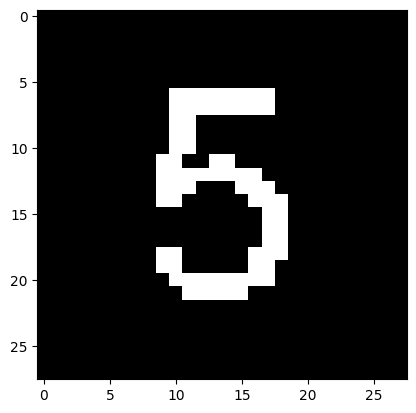

(5,3): Распознано число 5
(5,4): Пустая ячейка


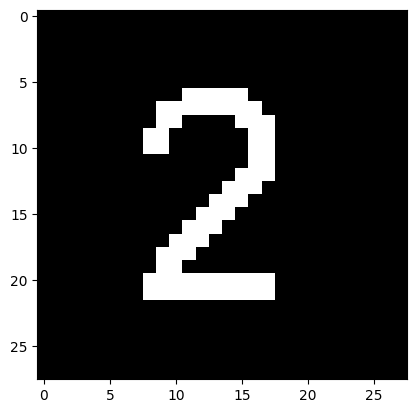

(5,5): Распознано число 2
(5,6): Пустая ячейка


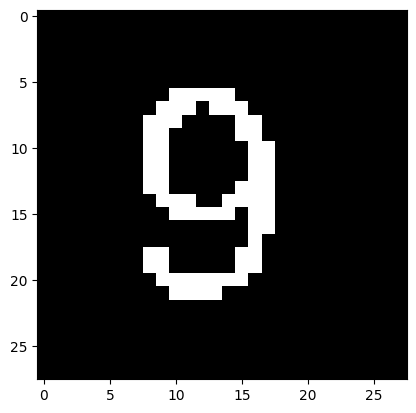

(5,7): Распознано число 9
(5,8): Пустая ячейка
(6,0): Пустая ячейка
(6,1): Пустая ячейка


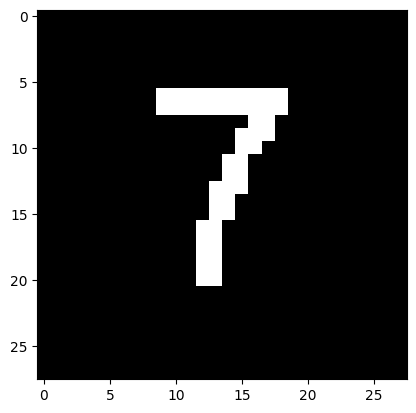

(6,2): Распознано число 7
(6,3): Пустая ячейка


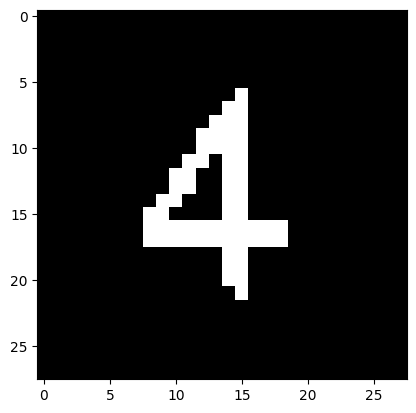

(6,4): Распознано число 4
(6,5): Пустая ячейка


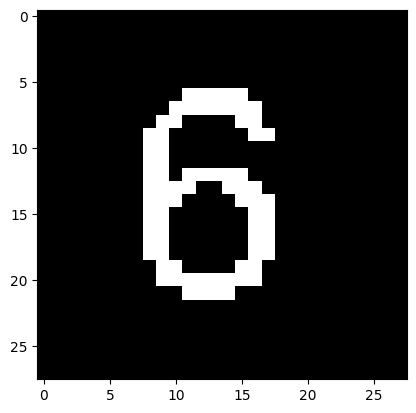

(6,6): Распознано число 6
(6,7): Пустая ячейка
(6,8): Пустая ячейка
(7,0): Пустая ячейка


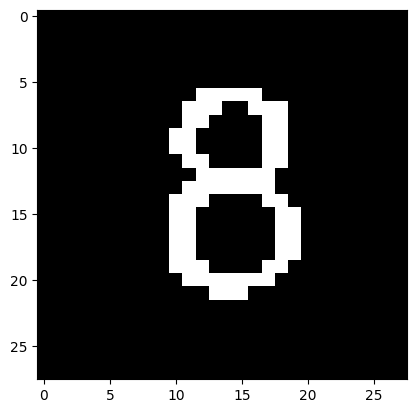

(7,1): Распознано число 6
(7,2): Пустая ячейка


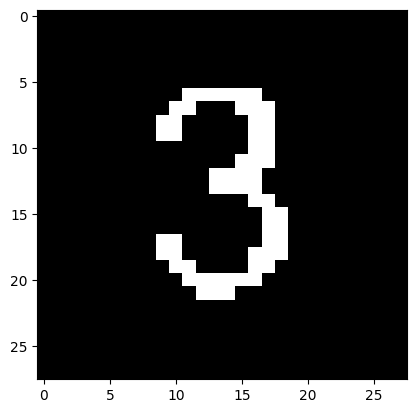

(7,3): Распознано число 3
(7,4): Пустая ячейка


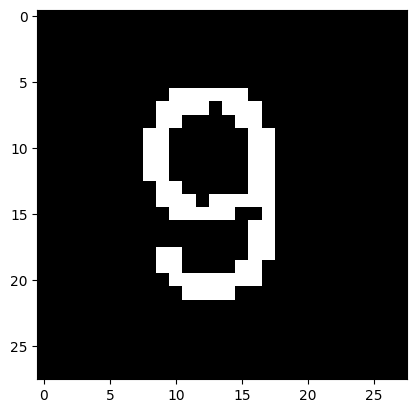

(7,5): Распознано число 9
(7,6): Пустая ячейка


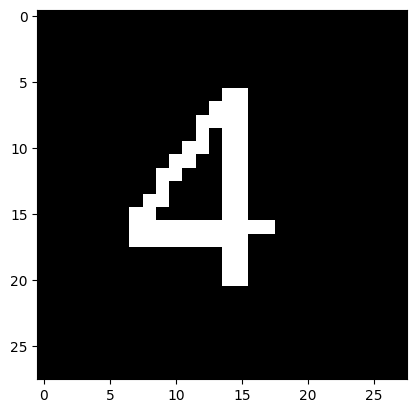

(7,7): Распознано число 4
(7,8): Пустая ячейка


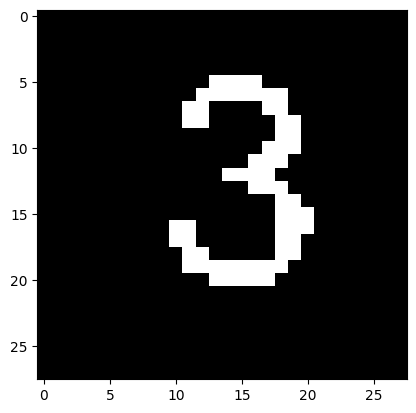

(8,0): Распознано число 3
(8,1): Пустая ячейка
(8,2): Пустая ячейка
(8,3): Пустая ячейка


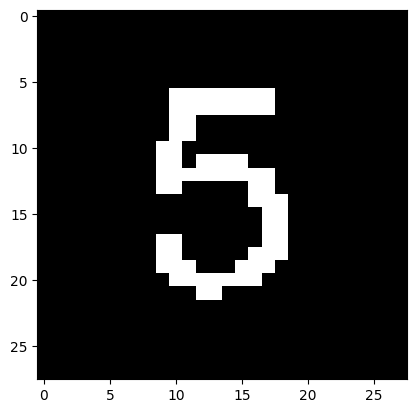

(8,4): Распознано число 5
(8,5): Пустая ячейка
(8,6): Пустая ячейка
(8,7): Пустая ячейка


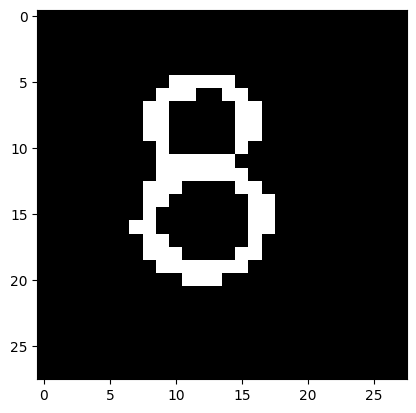

(8,8): Распознано число 8

Всего распознанных ячеек: 34
Всего пустых ячеек: 47


In [31]:
recognized_count = 0 # Кол-во ячеек с цифрами
empty_count = 0 # Кол-во пустых

for i in range(0, nRows):
    for j in range(0, nCols):
        bb = grid[i][j]

        # Если в bb нет конкуров, выведите об этом сообщение. Иначе, отправьте bb в нейронку
        # и выведите предсказание. Не забудьте, что bb имеет размерность (28,28),
        # а нейронка работает с тензорами размерности (batch_size,1,28,28).

        # Ищем контуры — если нет, считаем ячейку пустой
        contours, _ = cv2.findContours(bb, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0:
            print(f"({i},{j}): Пустая ячейка")
            empty_count += 1
        else:
            # Подготовим изображение к подаче в сеть
            bb_tensor = torch.tensor(bb, dtype=torch.float32) / 255.0  # нормализация
            bb_tensor = (bb_tensor - 0.1307) / 0.3081  # та же нормализация, что при обучении
            bb_tensor = bb_tensor.unsqueeze(0).unsqueeze(0).to(device)  # (1, 1, 28, 28)

            # Предсказание
            model.eval()
            with torch.no_grad():
                output = model(bb_tensor)
                pred = output.argmax(dim=1, keepdim=True)

            SHOW_IMAGE(grid[i][j])
            print(f"({i},{j}): Распознано число {pred.item()}")
            recognized_count += 1

print(f"\nВсего распознанных ячеек: {recognized_count}")
print(f"Всего пустых ячеек: {empty_count}")

C ошибками распознались следующие ячейки:
- (1,6) - Распознано число 1 - по факту Пустая ячейка;
- (3,1) - Распознано число 5 - по факту 6;
- (4,8) - Распознано число 2 - по факту 7;
- (7,1) - Распознано число 6 - по факту 8.


Увеличение batchsize, num_epoch и уменьшение learning_rate заметно улучшило модель - количество ошибок уменьшилось в 2 раза.

## Используем сверточную сеть с аугментацией и порогом уверенности

In [39]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Set random seed for reproducibility
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 10

# Augmentations for training set
train_transform = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.3),  # Искажение перспективы
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Normal transform for test
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           download=True,
                                           transform=train_transform)

test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False,
                                          download=True,
                                          transform=test_transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Define simple CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv(x)
        x = self.fc(x)
        return x

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

def test():
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = torch.max(output.data, 1)
            correct += (predicted == target).sum().item()

    accuracy = correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss/len(test_loader):.4f}, '
          f'Accuracy: {correct}/{len(test_loader.dataset)} ({100.*accuracy:.0f}%)\n')

# Train the model
for epoch in range(1, num_epochs + 1):
    train(epoch)
    test()

print("Training completed!")

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.314056
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.558667
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.476550
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.216496
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.106178
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.164313
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.281616
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.109441
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.051240
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.194510

Test set: Average loss: 0.0600, Accuracy: 9782/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.059812
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.098585
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.109793
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.018981
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.056075
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.037594
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.116148
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.202370
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.097096
T

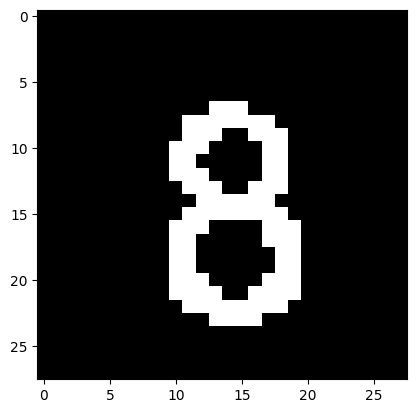

(0,0): Распознано число 8 (уверенность 1.00)
(0,1): Пустая ячейка (нет контуров)
(0,2): Пустая ячейка (нет контуров)
(0,3): Пустая ячейка (нет контуров)


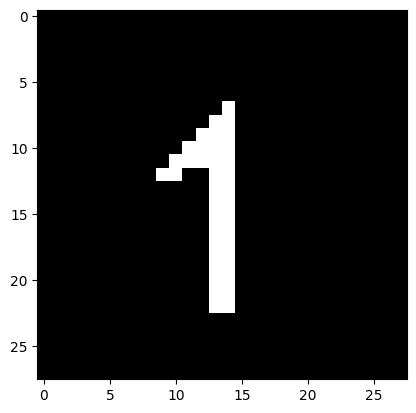

(0,4): Распознано число 1 (уверенность 0.72)
(0,5): Пустая ячейка (нет контуров)
(0,6): Пустая ячейка (нет контуров)
(0,7): Пустая ячейка (нет контуров)


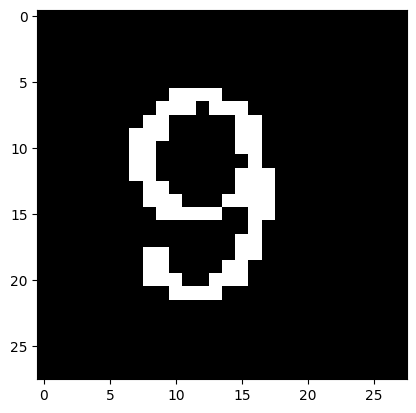

(0,8): Распознано число 9 (уверенность 0.98)
(1,0): Пустая ячейка (нет контуров)


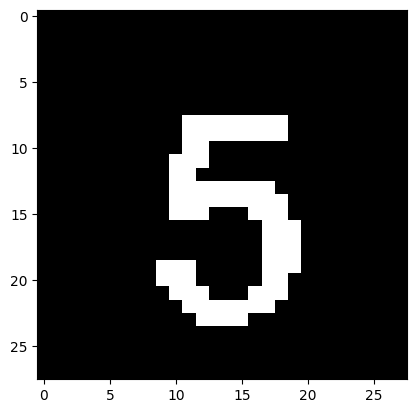

(1,1): Распознано число 5 (уверенность 1.00)
(1,2): Пустая ячейка (нет контуров)


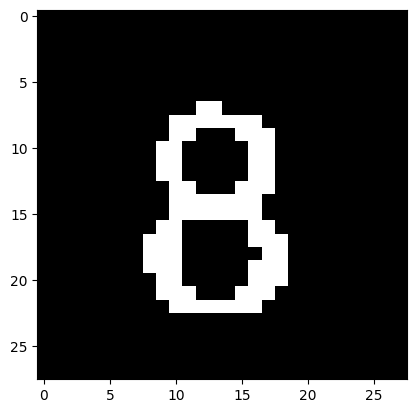

(1,3): Распознано число 8 (уверенность 1.00)
(1,4): Пустая ячейка (нет контуров)


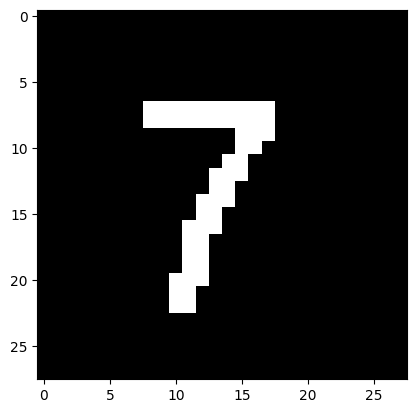

(1,5): Распознано число 7 (уверенность 1.00)
(1,6): Низкая уверенность (0.26) — игнорируем


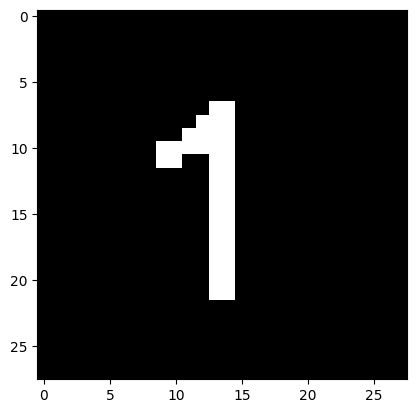

(1,7): Распознано число 7 (уверенность 0.65)
(1,8): Пустая ячейка (нет контуров)
(2,0): Пустая ячейка (нет контуров)
(2,1): Пустая ячейка (нет контуров)


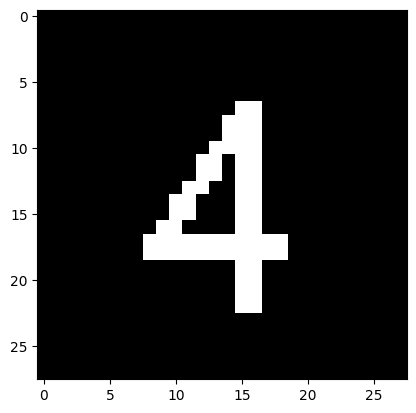

(2,2): Распознано число 4 (уверенность 1.00)
(2,3): Пустая ячейка (нет контуров)


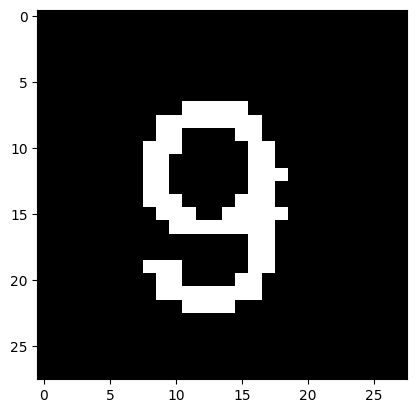

(2,4): Распознано число 9 (уверенность 1.00)
(2,5): Пустая ячейка (нет контуров)


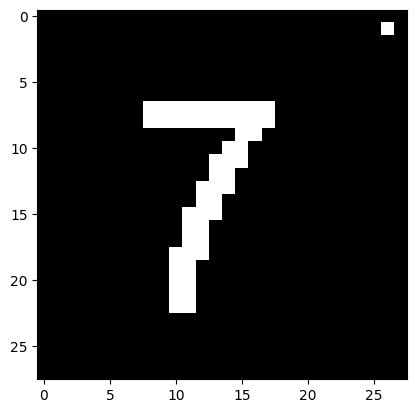

(2,6): Распознано число 7 (уверенность 1.00)
(2,7): Пустая ячейка (нет контуров)
(2,8): Пустая ячейка (нет контуров)
(3,0): Пустая ячейка (нет контуров)


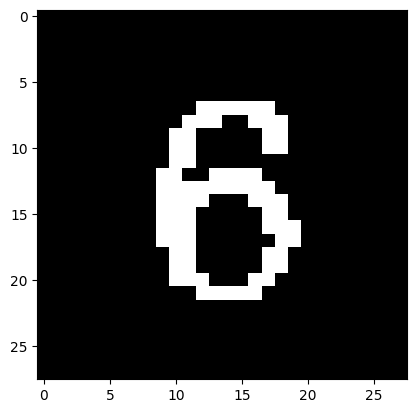

(3,1): Распознано число 6 (уверенность 0.69)
(3,2): Пустая ячейка (нет контуров)


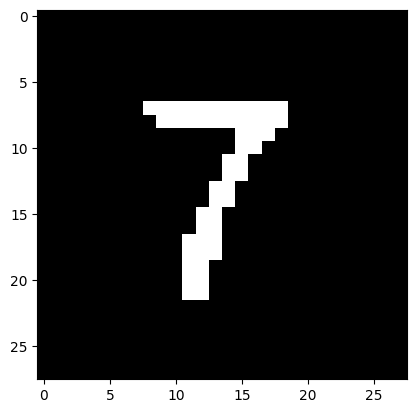

(3,3): Распознано число 7 (уверенность 1.00)
(3,4): Пустая ячейка (нет контуров)


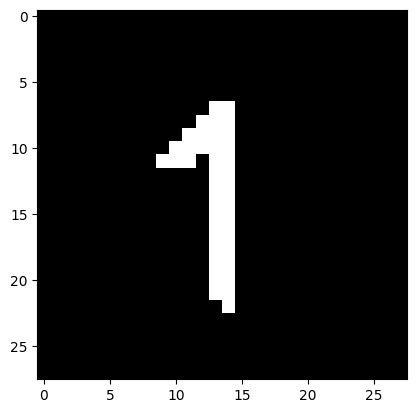

(3,5): Распознано число 1 (уверенность 0.70)
(3,6): Пустая ячейка (нет контуров)


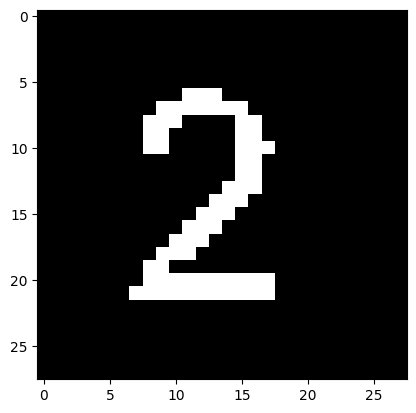

(3,7): Распознано число 2 (уверенность 1.00)
(3,8): Пустая ячейка (нет контуров)


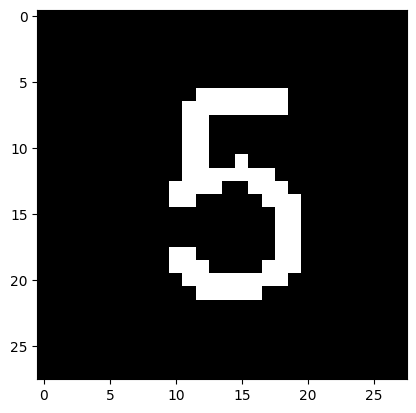

(4,0): Распознано число 5 (уверенность 1.00)
(4,1): Пустая ячейка (нет контуров)


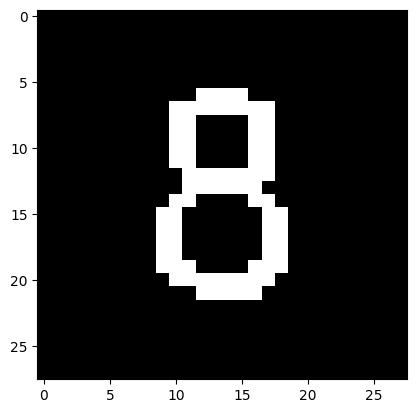

(4,2): Распознано число 8 (уверенность 1.00)
(4,3): Пустая ячейка (нет контуров)


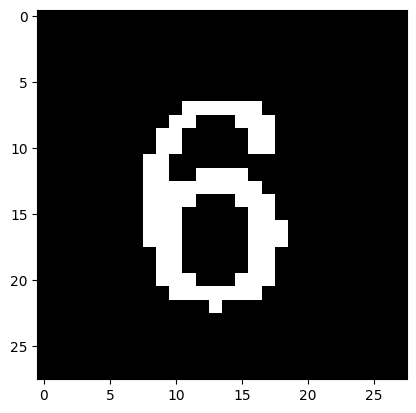

(4,4): Распознано число 8 (уверенность 0.76)
(4,5): Пустая ячейка (нет контуров)


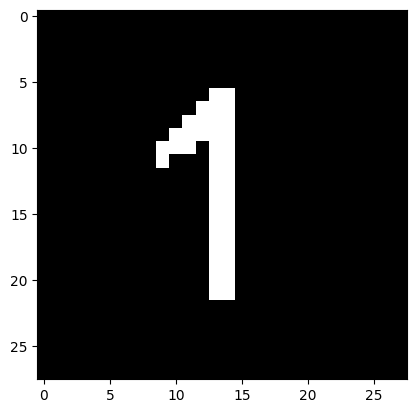

(4,6): Распознано число 7 (уверенность 0.46)
(4,7): Пустая ячейка (нет контуров)


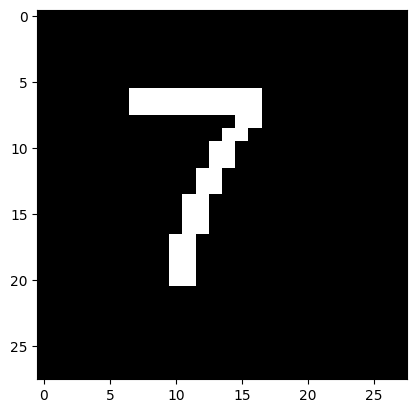

(4,8): Распознано число 7 (уверенность 1.00)
(5,0): Пустая ячейка (нет контуров)


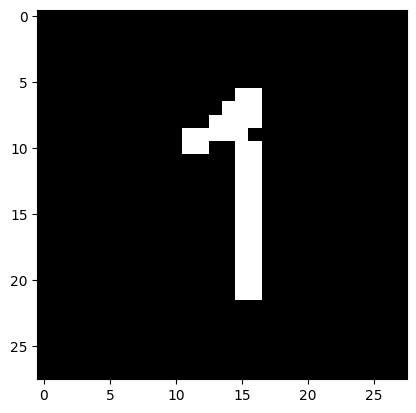

(5,1): Распознано число 1 (уверенность 0.96)
(5,2): Пустая ячейка (нет контуров)


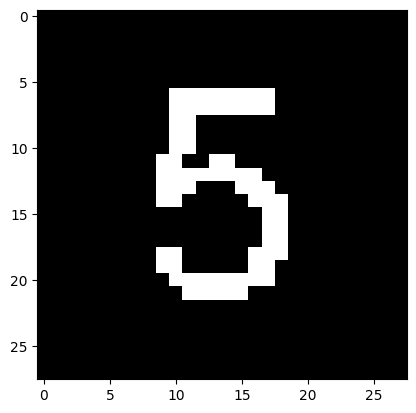

(5,3): Распознано число 5 (уверенность 1.00)
(5,4): Пустая ячейка (нет контуров)


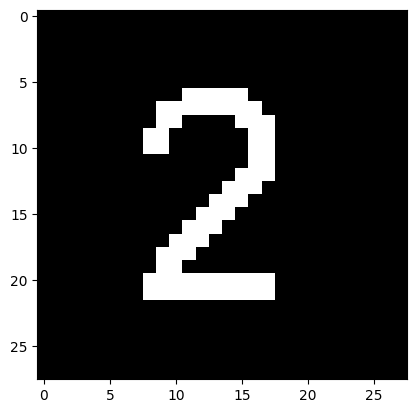

(5,5): Распознано число 2 (уверенность 1.00)
(5,6): Пустая ячейка (нет контуров)


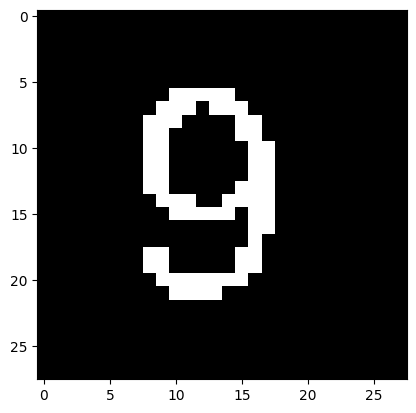

(5,7): Распознано число 9 (уверенность 1.00)
(5,8): Пустая ячейка (нет контуров)
(6,0): Пустая ячейка (нет контуров)
(6,1): Пустая ячейка (нет контуров)


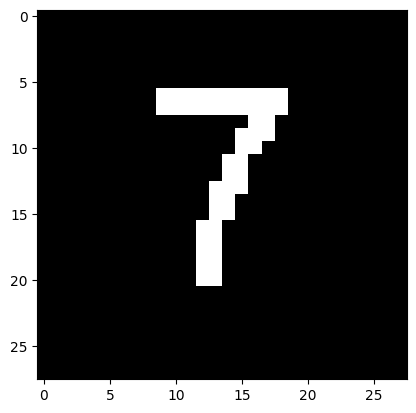

(6,2): Распознано число 7 (уверенность 1.00)
(6,3): Пустая ячейка (нет контуров)


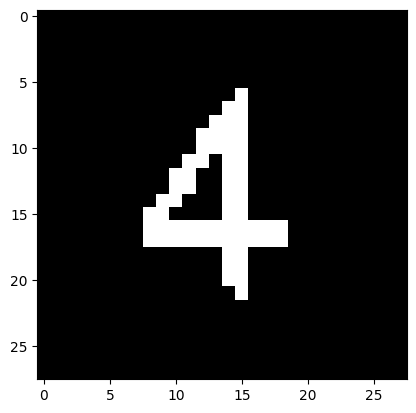

(6,4): Распознано число 4 (уверенность 1.00)
(6,5): Пустая ячейка (нет контуров)


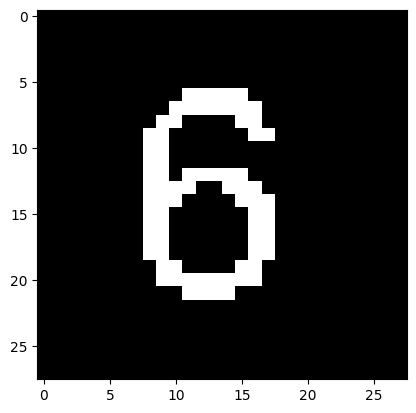

(6,6): Распознано число 8 (уверенность 0.50)
(6,7): Пустая ячейка (нет контуров)
(6,8): Пустая ячейка (нет контуров)
(7,0): Пустая ячейка (нет контуров)


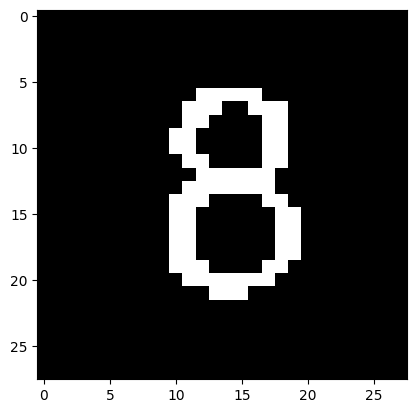

(7,1): Распознано число 8 (уверенность 1.00)
(7,2): Пустая ячейка (нет контуров)


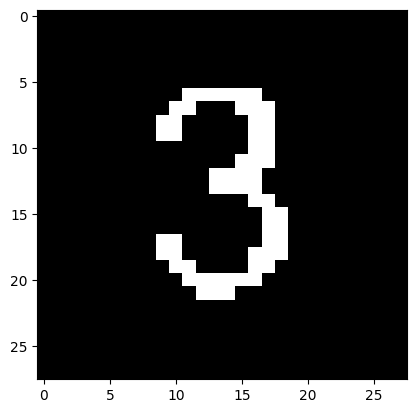

(7,3): Распознано число 3 (уверенность 1.00)
(7,4): Пустая ячейка (нет контуров)


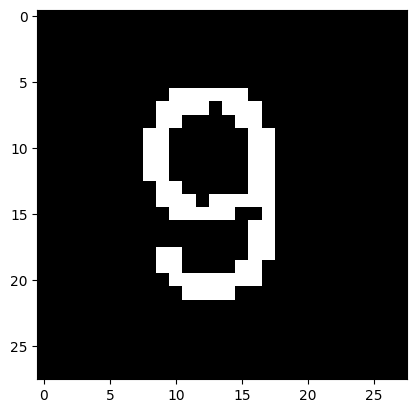

(7,5): Распознано число 9 (уверенность 0.99)
(7,6): Пустая ячейка (нет контуров)


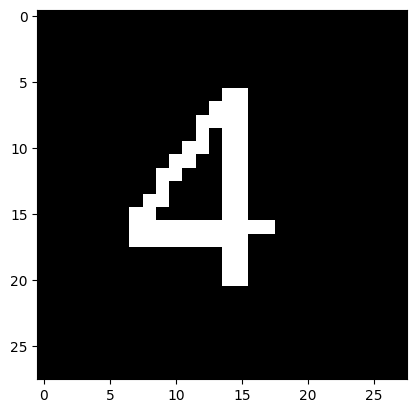

(7,7): Распознано число 4 (уверенность 1.00)
(7,8): Пустая ячейка (нет контуров)


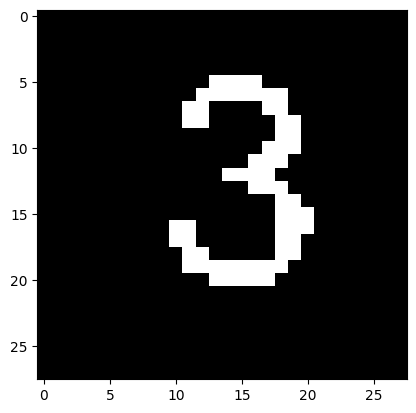

(8,0): Распознано число 3 (уверенность 1.00)
(8,1): Пустая ячейка (нет контуров)
(8,2): Пустая ячейка (нет контуров)
(8,3): Пустая ячейка (нет контуров)


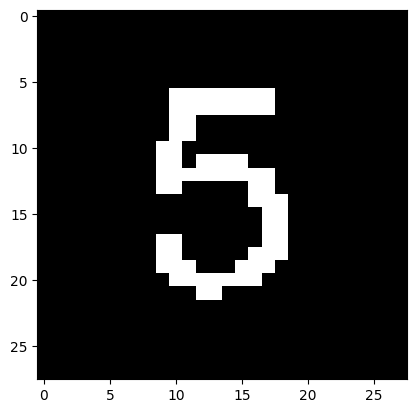

(8,4): Распознано число 5 (уверенность 1.00)
(8,5): Пустая ячейка (нет контуров)
(8,6): Пустая ячейка (нет контуров)
(8,7): Пустая ячейка (нет контуров)


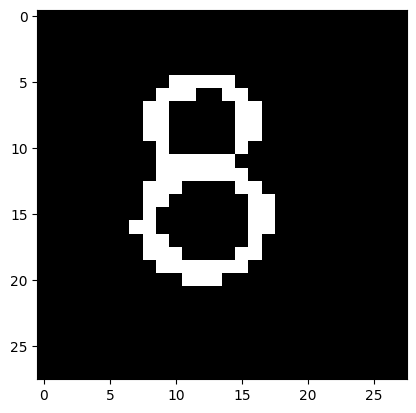

(8,8): Распознано число 8 (уверенность 1.00)

Всего распознанных ячеек: 33
Всего пустых ячеек: 48


In [41]:
recognized_count = 0
empty_count = 0

for i in range(nRows):
    for j in range(nCols):
        bb = grid[i][j]

        contours, _ = cv2.findContours(bb, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0:
            print(f"({i},{j}): Пустая ячейка (нет контуров)")
            empty_count += 1
        else:
            bb_tensor = torch.tensor(bb, dtype=torch.float32) / 255.0
            bb_tensor = (bb_tensor - 0.1307) / 0.3081
            bb_tensor = bb_tensor.unsqueeze(0).unsqueeze(0).to(device)

            model.eval()
            with torch.no_grad():
                output = model(bb_tensor)
                probs = torch.softmax(output, dim=1)
                confidence, pred = torch.max(probs, dim=1)

                # Предсказания с фильтрацией по уверенности
                if confidence.item() < 0.45:
                    print(f"({i},{j}): Низкая уверенность ({confidence.item():.2f}) — игнорируем")
                    empty_count += 1
                else:
                    SHOW_IMAGE(grid[i][j])
                    print(f"({i},{j}): Распознано число {pred.item()} (уверенность {confidence.item():.2f})")
                    recognized_count += 1

print(f"\nВсего распознанных ячеек: {recognized_count}")
print(f"Всего пустых ячеек: {empty_count}")

Проблема с пустой ячейкой (1,6) решилась путем задания порога уверенности.

C ошибками распознались следующие ячейки:
- (1,7) - Распознано число 7 (уверенность 0.65) - по факту 1;
- (4,4) - Распознано число 8 (уверенность 0.76) - по факту 6;
- (4,6) - Распознано число 7 (уверенность 0.46) - по факту 1.

В оправдание можно сказать, что 1 похожа на 7, а 8 похожа на 6 :) Но для прода такая модель не подойдет, необходимы доработки.

Итого: С помощью порога уверенности и сверточной сети получилось распознать все цифры и убрать лишние пустые ячейки. Но ошибки остались, возможно надо добавить еще аугментаций или поработать с исходным изображением.